In [8]:
import torch
d_model = 1 # number of features for a single "token"
model = torch.nn.Transformer(d_model=d_model, nhead=1)

In [2]:
src = torch.Tensor([1,2,3,4]).reshape((4,1,d_model))
tgt = torch.Tensor([1]).reshape((1,1,d_model))
model(src, tgt)

tensor([[[-3.4650e-11]]], grad_fn=<NativeLayerNormBackward0>)

In [ ]:
from utils import load_dataset
mosi = load_dataset(["CMU_MOSI_Visual_Facet_41"])

In [2]:
import torch
train_loader = torch.utils.data.DataLoader(mosi['train'], batch_size=32)
val_loader = torch.utils.data.DataLoader(mosi['val'], batch_size=32)
test_loader = torch.utils.data.DataLoader(mosi['test'], batch_size=32)

In [232]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(len(mosi['train'].features)-1, 1, dtype=torch.float64)
# )
model = torch.nn.Sequential(
    torch.nn.Linear(len(mosi['train'].features)-1, 16, dtype=torch.float64),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1, dtype=torch.float64)
)
model.to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

In [233]:
for epoch in range(10):
    running_loss = 0
    running_loss_test = 0
    model.train()
    for i, batch in enumerate(train_loader):
        optim.zero_grad()

        x = [v for (k,v) in batch.items() if k != "labels"]
        x2 = torch.stack(x)
        x2 = x2.transpose(1,0)
        x2 = x2.to('cuda')

        y_true = batch['labels']
        y_true = y_true.reshape(len(y_true), 1)
        y_true = y_true.double()
        y_true = y_true.to('cuda')

        y_pred = model(x2)

        loss = criterion(y_pred, y_true)
        loss.backward()
        optim.step()

        running_loss += loss.item()
    model.eval()
    for i, batch in enumerate(val_loader):
        x = [v for (k,v) in batch.items() if k != "labels"]
        x2 = torch.stack(x)
        x2 = x2.transpose(1,0)
        x2 = x2.to('cuda')

        y_true = batch['labels']
        y_true = y_true.reshape(len(y_true), 1)
        y_true = y_true.double()
        y_true = y_true.to('cuda')

        y_pred = model(x2)

        loss = criterion(y_pred, y_true)
        running_loss_test += loss.item()
    print("train loss", running_loss, "test loss", running_loss_test)

train loss 210.0266579382792 test loss 7.339679558707214
train loss 38.994797073727725 test loss 5.727442951995026
train loss 33.256383893024115 test loss 5.394704013139565
train loss 30.468844588557342 test loss 5.302394629501158
train loss 29.62120926444044 test loss 5.301207868709268
train loss 29.36236143777322 test loss 5.299933918402687
train loss 29.133164904069538 test loss 5.295820318891421
train loss 28.96052734712282 test loss 5.295522448678686
train loss 28.830065119448058 test loss 5.298278784327177
train loss 28.740948224803955 test loss 5.300905009389284


In [234]:
model.eval()
corrects = 0
total = 0
for i, batch in enumerate(test_loader):
    x = [v for (k,v) in batch.items() if k != "labels"]
    x2 = torch.stack(x)
    x2 = x2.transpose(1,0)
    x2 = x2.to('cuda')

    y_true = batch['labels']
    y_true = y_true.reshape(len(y_true), 1)
    y_true = y_true.to('cuda')

    y_pred = torch.sigmoid(model(x2))
    y_pred = y_pred.round()

    results = y_true == y_pred
    corrects += sum(results).item()
    total += len(results)
print(corrects / total)

0.5743440233236151


In [235]:
import shap
import shap.plots
omg = mosi['train'].remove_columns('labels').to_pandas()
omg2 = torch.Tensor(omg.to_numpy())

# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html
# "SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function."
def f(X):
    X2 = torch.Tensor(X)
    X2 = X2.to('cuda')
    X2 = X2.double()
    return model(X2).cpu().detach().numpy()

feat_names = [t for t in mosi['train'].features if t != "labels"]

explainer = shap.Explainer(f, omg.to_numpy(), feature_names=feat_names)
# explainer = shap.AdditiveExplainer(f, omg.to_numpy(), feature_names=feat_names)

In [236]:
x = [v for (k,v) in next(iter(test_loader)).items() if k != "labels"]
x2 = torch.stack(x)
x2 = x2.transpose(1,0)
x2 = x2.to('cuda')
print(model(x2))

tensor([[-0.3070],
        [-0.1565],
        [-0.2461],
        [-0.1872],
        [-0.4271],
        [-0.3743],
        [-0.3279],
        [-0.2780],
        [-0.3396],
        [-0.3806],
        [-0.4228],
        [-0.4355],
        [-0.4599],
        [-0.3939],
        [-0.2996],
        [-0.5622],
        [-0.4618],
        [-0.6052],
        [-0.4386],
        [-0.5838],
        [-0.4661],
        [-0.6247],
        [-0.6096],
        [-0.6468],
        [-0.6773],
        [-0.6285],
        [-0.5889],
        [-0.4877],
        [-0.5257],
        [-0.6412],
        [-0.6710],
        [-0.6400]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)


In [237]:
sample = x2[0]
# shap_values = explainer(omg.to_numpy())
shap_values = explainer(sample.reshape(1, len(sample)).cpu().numpy())

tensor([-0.3070], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


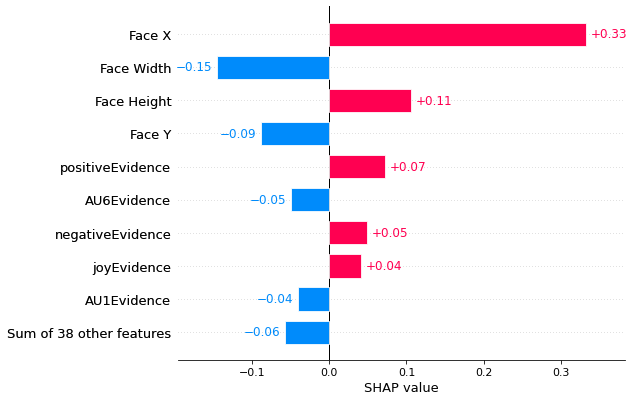

In [238]:
print(model(sample))

# PERMUTATION EXPLAINER
shap.plots.bar(shap_values[0,:])

# ADDITIVE EXPLAINER
# shap.plots.bar(shap_values[0,:,0])
# shap.plots.waterfall(shap_values[0,:,0])